# Chainer MNIST tutorial

http://docs.chainer.org/en/latest/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

### Use model from Keras tutorial

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

In [2]:
import numpy as np
np.random.seed(123)  # for reproducibility

### Load MNIST dataset

In [3]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [4]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [5]:
type(X_train)

numpy.ndarray

In [6]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


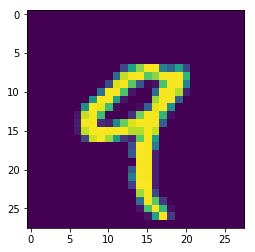

In [7]:
plt.imshow(X_train[4][0])

## Convert labels to 10 distinct class labels (one-hot)

In [8]:
print type(y_train[0])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print type(y_train[0])

<type 'numpy.uint8'>
<type 'numpy.int32'>


## Define model architecture

In [25]:
batchsize = 32
epoch = 12

In [51]:
# Model definition
class MLP(chainer.Chain):

    def __init__(self):
        super(MLP, self).__init__(
            l1 = L.Convolution2D(None, 32, (3,3)),
            l2 = L.Convolution2D(None, 32, (3,3)),
            l6 = L.Linear(None, 128),
            l8 = L.Linear(None, 10),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.max_pooling_2d(h2, (2,2))
        h4 = F.dropout(h3, 0.25)
        #print "H4 shape:", h4.shape
        h5 = F.reshape(h4,(h4.shape[0],h4.shape[1]*h4.shape[2]*h4.shape[3]))
        h6 = F.relu(self.l6(h5))
        h7 = F.dropout(h6, 0.5)
        h8 = F.softmax(self.l8(h7))
        return h8

In [52]:
model = L.Classifier(MLP(), lossfun = F.softmax_cross_entropy)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [53]:
from chainer.datasets import tuple_dataset
traning_dataset = tuple_dataset.TupleDataset(X_train, y_train)
test_dataset = tuple_dataset.TupleDataset(X_test, y_test)

In [54]:
from chainer.training import extensions

train_iter = chainer.iterators.SerialIterator(traning_dataset, batchsize)
test_iter = chainer.iterators.SerialIterator(test_dataset, batchsize,
                                                 repeat=False, shuffle=False)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=".")
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/accuracy', 'main/loss', 'validation/main/loss', 'validation/main/accuracy']))

In [55]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/loss  validation/main/accuracy
1           0.911417       1.55281                                                     
2           0.9548         1.50725                                                     
3           0.9617         1.49975                                                     
4           0.967          1.49419                                                     
5           0.9677         1.49348                                                     
6           0.9706         1.49045                                                     
7           0.971933       1.48921                                                     
8           0.973533       1.48761                                                     
9           0.97245        1.48852                                                     
10          0.974883       1.48626                                                     
11          0.97505        1.48588